In [1]:
import math
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import simsiam.loader
import simsiam.builder
import simsiam.resnet18
import simsiam.builder_resnet18
import simsiam.builder_resnet18_2

from sklearn.neighbors import KNeighborsClassifier


In [2]:
def kNN(model, train_loader, test_loader, device=torch.device('cuda'), k=15):
    
    model.eval()
    
    X_vec = torch.zeros((50000, 2048))
    y_vec = torch.zeros(50000)
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        #inputs, labels = inputs.to(device), labels.to(device)
        
        X = model.forward_lat(inputs).detach()
        y = labels

        X_vec[i*X.shape[0]:(i+1)*X.shape[0], :] = X
        y_vec[i*X.shape[0]:(i+1)*X.shape[0]] = y
            
    X = X_vec
    y = y_vec
            
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X.cpu(), y.cpu())
    
    def check_acc_train(model, classifier, test_loader):
    
        correct = 0
        total = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for i, data in enumerate(testloader):
                images, labels = data[0].to(device), data[1]
                outputs = model.forward_lat(images).detach().to('cpu')
                predicted = torch.tensor(classifier.predict(outputs))
                total += labels.size(0)

                correct += (predicted == labels).sum().item()

                #if i % 50 == 0:
                    #print(i, correct/total)

        print('Accuracy of the network on the 10000 training images: %d %%' % (
            100 * correct / total))
        return correct
    
    #model.train()
    
    return check_acc_train(model, classifier, test_loader)


In [3]:
#model_names = sorted(name for name in models.__dict__
#    if name.islower() and not name.startswith("__")
#    and callable(models.__dict__[name]))
#print(model_names)
#model = simsiam.builder.SimSiam(
#        models.__dict__['resnet18'],
#        2048, 1024)

#model = simsiam.builder.SimSiam(
#        simsiam.resnet.resnet20(),
#        16, 8)

model = simsiam.resnet18.resnet18()
#for child in model.children():
#    for layer in child.modules():
#        print(layer)
model = simsiam.builder_resnet18_2.SimSiam(model, 2048, 512, stop_grad=True, include_predictor=True)

device = torch.device('cuda') 
lr = 0.03
# batch_size = 512, workers = 32
batch_size = 512
workers = 4
momentum = 0.9
weight_decay = 0.0005
start_epoch = 99
epochs = 100

init_lr = lr * batch_size / 256
criterion = nn.CosineSimilarity(dim=1)

model.to(device)

model = torch.load("fixlr98.pt")

optim_params = [{'params': model.encoder.parameters(), 'fix_lr': True},
                        {'params': model.predictor.parameters(), 'fix_lr': True}]

#optim_params = [{'params': model.encoder.parameters(), 'fix_lr': False}]

optimizer = torch.optim.SGD(optim_params, init_lr,
                                momentum=momentum,
                                weight_decay=weight_decay)

normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.2023, 0.1994, 0.2010])

    # MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
augmentation = [
    transforms.RandomResizedCrop(28, scale=(0.2, 1.)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    #transforms.RandomApply([simsiam.loader.GaussianBlur([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
    ]


data_storage = "./data"

    
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.2023, 0.1994, 0.2010])
    
transform_test = [transforms.ToTensor(), normalize]

testset = torchvision.datasets.CIFAR10(root=data_storage, train=False, download=True, transform=transforms.Compose(transform_test))

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                     std=[0.2023, 0.1994, 0.2010])
augmentation = [
    transforms.RandomResizedCrop(28, scale=(0.2, 1.)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    #transforms.RandomApply([simsiam.loader.GaussianBlur([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
    ]


data_storage = "./data"

kNNtrainset = torchvision.datasets.CIFAR10(root="./data/cifar", train=True,
                                        download=True, transform=transforms.Compose(augmentation))

#train_dataset = datasets.ImageFolder(traindir,
#        simsiam.loader.TwoCropsTransform(transforms.Compose(augmentation)))

kNNtrain_loader = torch.utils.data.DataLoader(kNNtrainset, batch_size = 64, shuffle= False, num_workers=0)

kNNdata = []
for i, data in enumerate(kNNtrain_loader):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        kNNdata.append([inputs, labels])
        
kNNtrain_loader = kNNdata

trainset = torchvision.datasets.CIFAR10(root=data_storage, train=True,
                                        download=True, transform=simsiam.loader.TwoCropsTransform(transforms.Compose(augmentation)))

#train_dataset = datasets.ImageFolder(traindir,
#        simsiam.loader.TwoCropsTransform(transforms.Compose(augmentation)))

train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle= True,
        num_workers=workers, pin_memory=True, drop_last=True)

#print(device)

#model.load_state_dict(torch.load("nets/simsiam_resnet18_v2.pt"))


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
def train(train_loader, model, criterion, optimizer, epoch, gpu = None, kNNtrain_loader=kNNtrain_loader, test_loader=testloader, knn=False):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses],
        prefix="Epoch: [{}]".format(epoch))
    
    # switch to train mode
    
    #print(kNN(model, kNNtrain_loader, test_loader))
    
    model.train()

    end = time.time()
    
    epoch_loss = 0
    zs = []

    for i, (images, _) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if gpu is not None:
            images[0] = images[0].cuda(args.gpu, non_blocking=True)
            images[1] = images[1].cuda(args.gpu, non_blocking=True)
        
        images[0], images[1] = images[0].to(device), images[1].to(device)
        # compute output and loss
     
        p1, p2, z1, z2 = model(x1=images[0], x2=images[1])
        loss = -(criterion(p1, z2).mean() + criterion(p2, z1).mean()) * 0.5

        losses.update(loss.item(), images[0].size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        if i % 10 == 0:
            progress.display(i)
            
        zs.append([z1, z2])
        
        #kNN_score = kNN(model, kNNtrain_loader, test_loader)
        
    if knn:
        kNN_score = kNN(model, kNNtrain_loader, test_loader)
    else:
        kNN_score = False
            
            
    return (losses.avg, losses.sum, kNN_score, zs)


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def adjust_learning_rate(optimizer, init_lr, epoch, epochs):
    """Decay the learning rate based on schedule"""
    cur_lr = init_lr * 0.5 * (1. + math.cos(math.pi * epoch / epochs))
    for param_group in optimizer.param_groups:
        if 'fix_lr' in param_group and param_group['fix_lr']:
            param_group['lr'] = init_lr
        else:
            param_group['lr'] = cur_lr

In [5]:
# Trained 100 epochs
#model.load_state_dict(torch.load('nets/simsiam_resnet18_v2.pt'))
kNNs = []
losses = []
zs = []

for epoch in range(start_epoch, epochs):
    knn = False
    #if epoch % 5 == 0:
    #    knn = True
    
    #adjust_learning_rate(optimizer, init_lr, epoch, epochs)
    loss = train(train_loader, model, criterion, optimizer, epoch, knn=knn)
    losses.append(loss[0])
    kNNs.append(loss[-2])
    zs.append(loss[-1])
    


Epoch: [99][ 0/97]	Time  2.912 ( 2.912)	Data  1.473 ( 1.473)	Loss -0.8440 (-0.8440)
Epoch: [99][10/97]	Time  0.653 ( 1.215)	Data  0.000 ( 0.134)	Loss -0.8629 (-0.8586)
Epoch: [99][20/97]	Time  0.654 ( 0.947)	Data  0.000 ( 0.070)	Loss -0.8512 (-0.8533)
Epoch: [99][30/97]	Time  0.659 ( 0.853)	Data  0.000 ( 0.048)	Loss -0.8423 (-0.8511)
Epoch: [99][40/97]	Time  0.663 ( 0.806)	Data  0.000 ( 0.036)	Loss -0.8498 (-0.8519)
Epoch: [99][50/97]	Time  0.671 ( 0.778)	Data  0.000 ( 0.029)	Loss -0.8509 (-0.8525)
Epoch: [99][60/97]	Time  0.669 ( 0.760)	Data  0.000 ( 0.024)	Loss -0.8590 (-0.8529)
Epoch: [99][70/97]	Time  0.671 ( 0.748)	Data  0.000 ( 0.021)	Loss -0.8546 (-0.8526)
Epoch: [99][80/97]	Time  0.679 ( 0.738)	Data  0.000 ( 0.018)	Loss -0.8502 (-0.8526)
Epoch: [99][90/97]	Time  0.680 ( 0.731)	Data  0.000 ( 0.016)	Loss -0.8448 (-0.8516)


In [ ]:
torch.cuda.is_available()

In [6]:
torch.save(model, "fixlr100.pt")

In [7]:
import numpy as np
final = []
for epoch in zs:
    epoch_vec = []
    for batch in epoch:
        for idx in batch:
            nmp = idx.detach().cpu().numpy()
            for i in range(nmp.shape[0]):
                l2 = nmp[i, :]/np.sqrt(np.sum(np.square(nmp[i, :])))
                epoch_vec.append(np.std(l2))
    final.append(epoch_vec)
            
print(len(final[0]))
        
            

99328


In [8]:
aa = [np.mean(x) for x in final]
print(aa)

[0.022096911, 0.022096911, 0.022096913, 0.022096911, 0.022096911, 0.022096911, 0.022096911, 0.022096911]


In [7]:
import pandas as pd
df = pd.DataFrame({"losses": losses, "kNN": kNNs})
df.to_csv("fixlr100.csv")

In [12]:
kNNs

[2544,
 False,
 False,
 False,
 False,
 2548,
 False,
 False,
 False,
 False,
 2535,
 False]

In [11]:
import pandas as pd
a = pd.read_csv("nosg_stats_epoch9.csv")
b = pd.read_csv("sg_stats_epoch19.csv")
print(a)
print(b)

   Unnamed: 0    losses    kNN       std
0           0 -0.744611    983  0.022091
1           1 -0.980979  False  0.022093
2           2 -0.985250  False  0.022093
3           3 -0.991743  False  0.022093
4           4 -0.993088  False  0.022093
5           5 -0.984817    990  0.022093
6           6 -0.984730  False  0.022093
7           7 -0.988784  False  0.022093
8           8 -0.992397  False  0.022093
    Unnamed: 0    losses    kNN       std
0            0 -0.733413  False  0.022084
1            1 -0.732542   2502  0.022084
2            2 -0.736271  False  0.022084
3            3 -0.734811  False  0.022084
4            4 -0.732358  False  0.022084
5            5 -0.735565  False  0.022084
6            6 -0.732085   2572  0.022084
7            7 -0.733680  False  0.022084
8            8 -0.734609  False  0.022084
9            9 -0.735887  False  0.022085
10          10 -0.733427  False  0.022084


In [102]:
len(zs[0])
794624

97

In [115]:
d = zs[0][0][0].shape[1]
print(1/np.sqrt(d))

0.022097086912079608


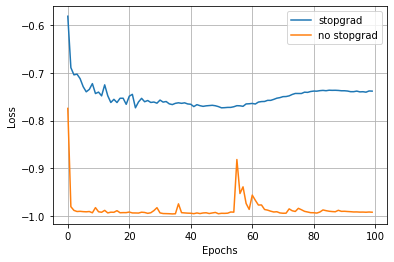

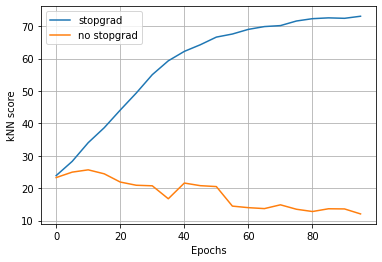

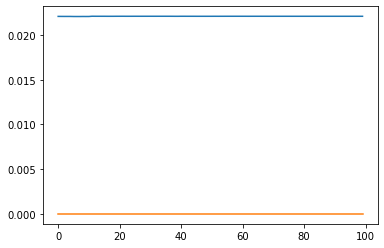

In [10]:
import matplotlib.pyplot as plt

df = pd.read_csv("sstopgrad.csv")
df2 = pd.read_csv("nostopgrad.csv")

plt.figure(1)
plt.plot(list(range(len(df["losses"]))), df["losses"], label="stopgrad")
plt.plot(list(range(len(df2["losses"]))), df2["losses"], label="no stopgrad")
plt.grid()
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("Loss")
plt.savefig("stopgradloss.jpg") #save as jpg
plt.savefig("stopgradloss.png")

knn = df["kNN"].to_numpy()
kn = []
knnn = df2["kNN"].to_numpy()
ka = []
for k, i in zip(knn, knnn):
    if not k == 'False':
        kn.append(int(k)/100)
    if not i == 'False':
        ka.append(int(i)/100)

plt.figure(2)
plt.plot(list(range(0, 100, 5)), kn, label="stopgrad")
plt.plot(list(range(0, 100, 5)), ka, label="no stopgrad")
#plt.xticks(list(range(0, 100, 5)))
plt.grid()
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("kNN score")
plt.savefig("stopgradkNN.jpg") #save as jpg
plt.savefig("stopgradkNN.png")

plt.figure(3)
plt.plot(list(range(len(df["std"]))), df["std"])
plt.plot(list(range(len(df["std"]))), np.zeros_like(df["std"]))

### Linear eval on stopgrad: 0.5974
### Linear eval wo stopgrad: 0.1654

### Linear eval wo predictor: 0.0974
### Linear eval with fix lr: 0.6451

import matplotlib.pyplot as plt
 


In [10]:
files = ["stopgrad10.csv", "test21.csv", "test32.csv", "test43.csv", "test54.csv", "test65.csv", "test76.csv", "test87.csv", "test98.csv", "test100.csv"]

frames = []

for file in files:
    df = pd.read_csv(file)
    frames.append(df)
    
result = pd.concat(frames)
result.to_csv("sstopgrad.csv")

print(result)
    


    Unnamed: 0    losses    kNN       std
0            0 -0.581424   2388  0.022078
1            1 -0.689031  False  0.022076
2            2 -0.704107  False  0.022074
3            3 -0.702589  False  0.022074
4            4 -0.712043  False  0.022074
..         ...       ...    ...       ...
7            7 -0.739770   7308  0.022091
8            8 -0.739428  False  0.022091
9            9 -0.740405  False  0.022091
10          10 -0.737838  False  0.022091
0            0 -0.738213  False  0.022091

[100 rows x 4 columns]


In [11]:
kNN_score = kNN(model, kNNtrain_loader, testloader)
print(kNN_score)

Accuracy of the network on the 10000 training images: 12 %
1252


In [43]:
kn

[13.92,
 22.69,
 24.45,
 38.66,
 44.11,
 49.37,
 55.04,
 59.32,
 62.23,
 64.28,
 66.64,
 67.59,
 69.03,
 69.89,
 70.19,
 71.61,
 72.33,
 72.58,
 72.44,
 73.08]

In [34]:
mask = np.where(knn != 'False', 1, 0)
mask

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [36]:
knn[mask]

array(['False', '1392', '1392', '1392', '1392', 'False', '1392', '1392',
       '1392', '1392', 'False', '1392', '1392', '1392', '1392', 'False',
       '1392', '1392', '1392', '1392', 'False', '1392', '1392', '1392',
       '1392', 'False', '1392', '1392', '1392', '1392', 'False', '1392',
       '1392', '1392', '1392', 'False', '1392', '1392', '1392', '1392',
       'False', '1392', '1392', '1392', '1392', 'False', '1392', '1392',
       '1392', '1392', 'False', '1392', '1392', '1392', '1392', 'False',
       '1392', '1392', '1392', '1392', 'False', '1392', '1392', '1392',
       '1392', 'False', '1392', '1392', '1392', '1392', 'False', '1392',
       '1392', '1392', '1392', 'False', '1392', '1392', '1392', '1392',
       'False', '1392', '1392', '1392', '1392', 'False', '1392', '1392',
       '1392', '1392', 'False', '1392', '1392', '1392', '1392', 'False',
       '1392', '1392', '1392', '1392'], dtype=object)

In [41]:
list(range(0, 100, 5))

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]